<a href="https://colab.research.google.com/github/GabrielBatavia/LearningML/blob/main/BitsAndBytes_8_bit_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get Ready the resource

In [1]:
pip install torch transformers datasets bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

### Dataset

In [2]:
from datasets import load_dataset

# Load IMDb dataset
dataset = load_dataset('imdb')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Visualize

In [4]:
pip install matplotlib seaborn


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# Convert to DataFrame for easier manipulation
df_train = pd.DataFrame(dataset['train'])

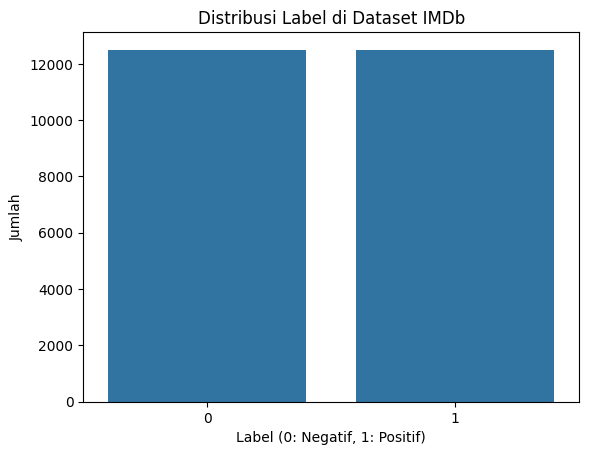

In [7]:
# Plot label distribution
sns.countplot(x='label', data=df_train)
plt.title('Distribusi Label di Dataset IMDb')
plt.xlabel('Label (0: Negatif, 1: Positif)')
plt.ylabel('Jumlah')
plt.show()

In [8]:
# Calculate text lengths
df_train['text_length'] = df_train['text'].apply(len)

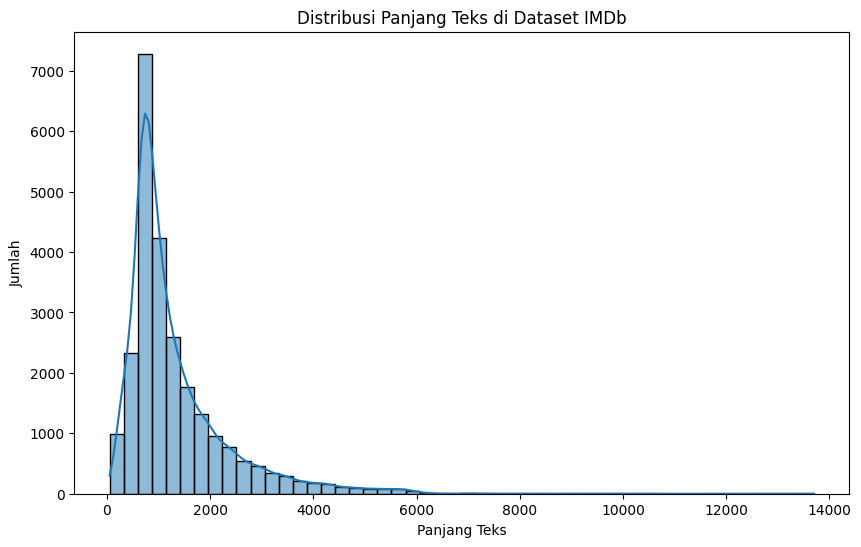

In [9]:
# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Teks di Dataset IMDb')
plt.xlabel('Panjang Teks')
plt.ylabel('Jumlah')
plt.show()

In [10]:
from collections import Counter
import re

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Preprocess text and count word frequencies
df_train['clean_text'] = df_train['text'].apply(preprocess_text)
all_words = ' '.join(df_train['clean_text']).split()
word_freq = Counter(all_words)


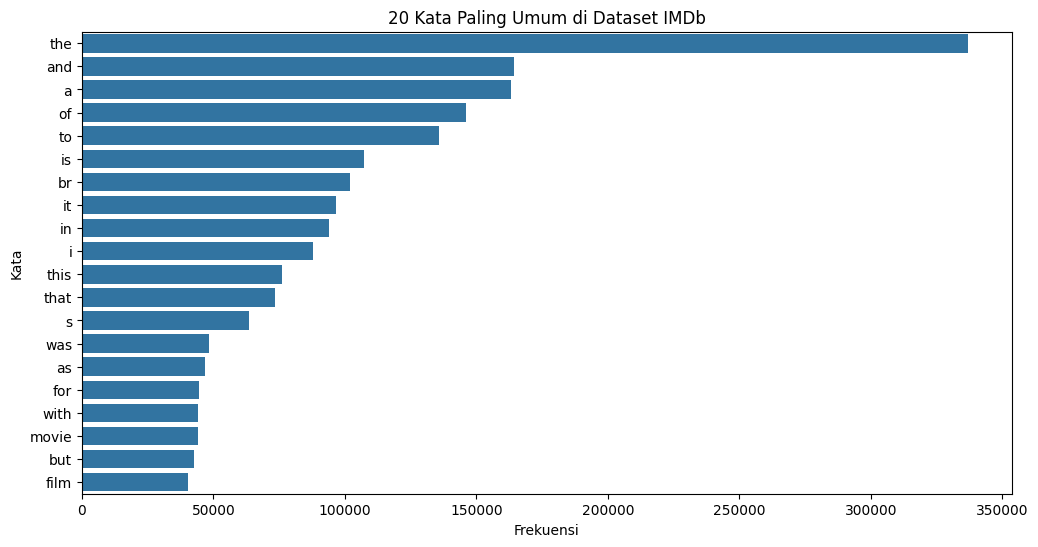

In [11]:
# Get the most common words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Plot word frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=words)
plt.title('20 Kata Paling Umum di Dataset IMDb')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

### Build the model

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model with BitsAndBytes 8-bit Optimizer

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from bitsandbytes import optim as bnb_optim

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create data loaders
train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(1000))  # Select a small subset for demonstration
train_loader = DataLoader(train_dataset, batch_size=8)

# Define the 8-bit optimizer
optimizer = bnb_optim.Adam8bit(model.parameters(), lr=5e-5)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Training loop
model.train()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(3):  # Train for 3 epochs
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key in tokenizer.model_input_names}
        optimizer.zero_grad()
        outputs = model(**inputs, labels=inputs['label'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Save the trained model
model.save_pretrained('./bert-8bit')